# Prepare Environment

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as patches
import plotly.express as px
import urllib.request

# Import and Clean Up Poverty Estimate Data

In [2]:
# Read Poverty Estimate File

# URL of Excel file
url = "https://github.com/johnnydrodriguez/data608_story6/blob/main/PovertyEstimates.xlsx?raw=true"

# Download the Excel file from the provided URL
urllib.request.urlretrieve(url, "PovertyEstimates.xlsx")

# Load the first sheet of the Excel file into a DataFrame, skipping the first 4 rows
poverty_df = pd.read_excel('PovertyEstimates.xlsx', sheet_name=0, skiprows=4)

# Keep only specified columns
cols_to_keep = ['Stabr', 'POVALL_2021', 'PCTPOVALL_2021', 'POV017_2021', 'PCTPOV017_2021',
                'POV517_2021', 'PCTPOV517_2021', 'MEDHHINC_2021', 'POV04_2021', 'PCTPOV04_2021']
poverty_df = poverty_df[cols_to_keep]

# Rename column
poverty_df = poverty_df.rename(columns={'Stabr': 'State'})

# Insert 'Year' column at index 1
poverty_df.insert(1, 'Year', 2021)

# 2. Drop row where Stabr = 'US'
poverty_df = poverty_df[poverty_df.State != 'US']

# 3. Keep only first instance of each Stabr
poverty_df.drop_duplicates(subset='State', keep='first', inplace=True)

# Import and Clean Up Food Insecurity Data

In [3]:
# Read the Food Insecurity File
url = "https://github.com/johnnydrodriguez/data608_story6/blob/main/MMG2023_2019-2021_Data_ToShare.xlsx?raw=true"

# Download the Excel file from the provided URL
urllib.request.urlretrieve(url, "data.xlsx")

# Load the fourth sheet of the Excel file into a DataFrame
food_df = pd.read_excel('data.xlsx', sheet_name=3)

# Remove whitespace from column names
food_df.columns = food_df.columns.str.replace('\s+', '', regex=True)

# Indices of columns to keep
cols_to_keep = [2, 3, 4, 17, 18, 21, 22, 25, 26]

# Keep only the specified columns in the DataFrame
food_df = food_df[food_df.columns[cols_to_keep]]

# Merge Poverty and Food Insecurity Data for Visualizations

In [4]:
# Merge poverty_df and food_df on the 'State' column (and 'Year' column)
merged_df = pd.merge(poverty_df, food_df,
                     how='right',
                     left_on=['State', 'Year'],  # Changed 'Stabr' to 'State'
                     right_on=['State', 'Year'])

# Get list of column names from both DataFrames
left_cols = poverty_df.columns.tolist()
right_cols = food_df.columns.tolist()

# Combine column names, ensuring no duplicates
merged_cols = left_cols + [c for c in right_cols if c not in left_cols]

# Reorder columns in the merged DataFrame according to the combined list
merged_df = merged_df[merged_cols]

# Clean Up Merged Data Frame

In [5]:
# List of columns to convert
columns_to_convert = ['PCTPOVALL_2021', 'PCTPOV017_2021', 'PCTPOV517_2021', 'PCTPOV04_2021']

# Convert each column from percentage to decimal
for column in columns_to_convert:
    merged_df[column] = merged_df[column].astype(float) / 100

# Rename columns dictionary
rename_columns = {
    'PCTPOVALL_2021': 'Poverty_Rate_overall_2021',
    'PCTPOV017_2021': 'Poverty_Rate_under17_2021',
    'PCTPOV517_2021': 'Poverty_Rate_5to17_2021',
    'PCTPOV04_2021': 'Poverty_Rate_under4_2021',
    'MEDHHINC_2021': 'Median_Inc_2021',
    'SeniorFoodInsecurityRate(StateofSeniorHunger)': 'SeniorFoodInsecurityRate',
    'OlderAdultFoodInsecurityRate(StateofSeniorHunger)': 'OlderAdultFoodInsecurityRate'}

# Rename the columns
merged_df.rename(columns=rename_columns, inplace=True)

# Visualization: Food Insecurity Rates Line Plot by Year and Category


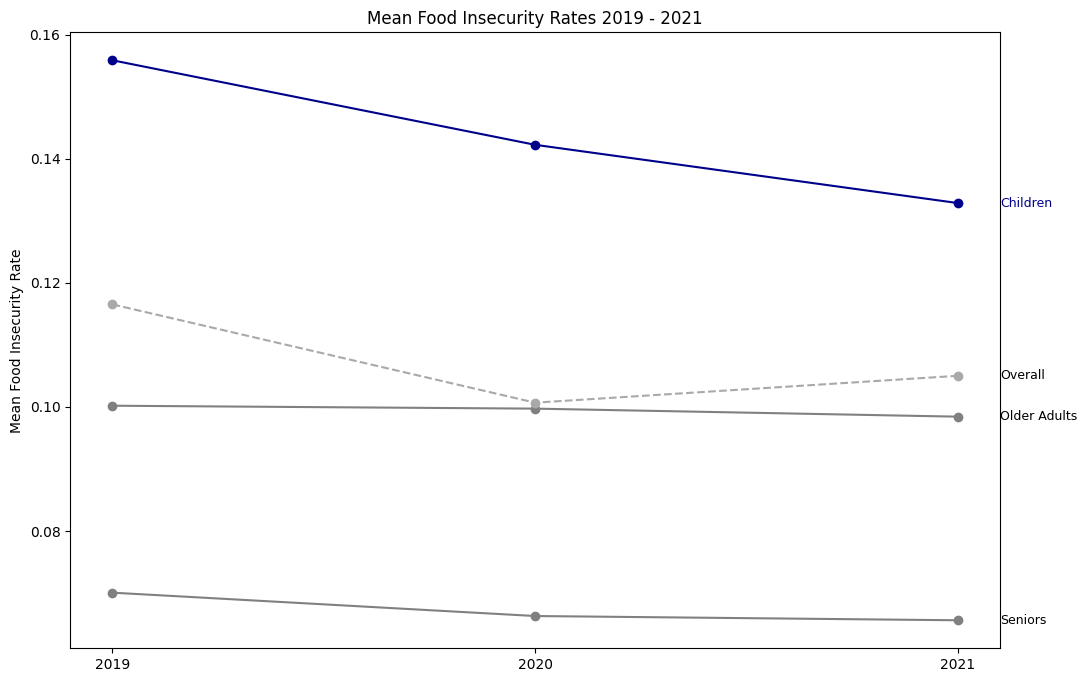

In [16]:
# Calculate the mean food insecurity rate for each category per year
mean_children = merged_df.groupby('Year')['ChildFoodInsecurityRate'].mean()
mean_older_adults = merged_df.groupby('Year')['OlderAdultFoodInsecurityRate'].mean()
mean_seniors = merged_df.groupby('Year')['SeniorFoodInsecurityRate'].mean()
mean_overall = merged_df.groupby('Year')['OverallFoodInsecurityRate'].mean()

# Plot
plt.figure(figsize=(12, 8))

# Plot seniors and older adults in light gray
plt.plot(mean_seniors, marker='o', color='gray', label='Seniors')
plt.plot(mean_older_adults, marker='o', color='gray', label='Older Adults')

# Plot children in dark blue
plt.plot(mean_children, marker='o', color='darkblue', label='Children')

# Plot the overall rate in red with a different line style
plt.plot(mean_overall, marker='o', linestyle='--', color='darkgray', label='Overall')

# Add titles and labels
plt.title('Mean Food Insecurity Rates 2019 - 2021')
plt.xlabel('Year')
plt.ylabel('Mean Food Insecurity Rate')

# Setting x-axis to only show full years
plt.xticks([2019, 2020, 2021])

# Labeling each line directly on the plot
for category, data, color in zip(['Seniors', 'Older Adults', 'Children', 'Overall'],
                                 [mean_seniors, mean_older_adults, mean_children, mean_overall],
                                 ['black', 'black', 'darkblue', 'black']):
    # Label the last point of each line
    plt.text(data.index[-1] + 0.1, data.iloc[-1], category, fontsize=9, verticalalignment='center', color=color)

# Remove the 'Year' label from the x-axis
plt.xlabel('')

plt.show()

# Visualization: Stacked Bar for Proportion of Children Food Insecurity by State

<Figure size 1500x1000 with 0 Axes>

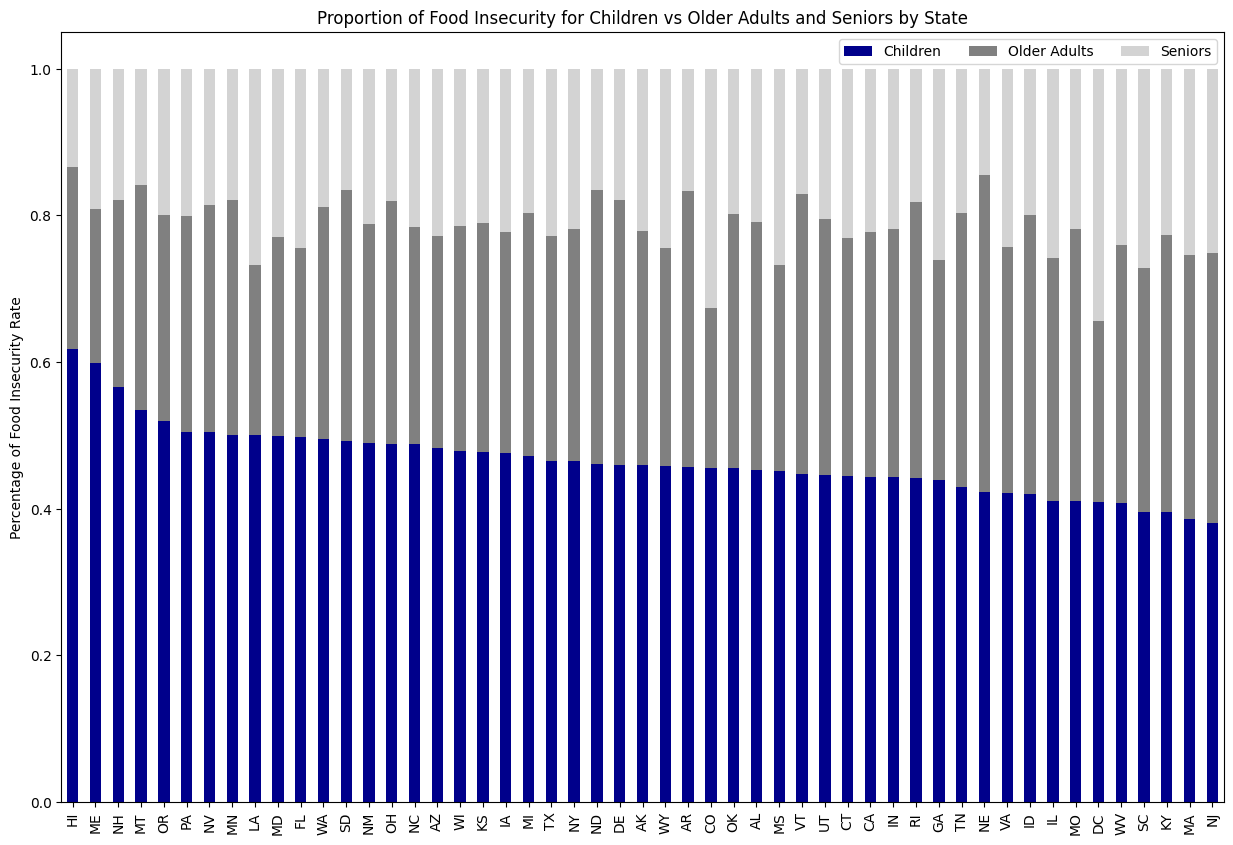

In [17]:
# Calculate the mean food insecurity rate for each category per state
mean_children_by_state = merged_df.groupby('State')['ChildFoodInsecurityRate'].mean()
mean_older_adults_by_state = merged_df.groupby('State')['OlderAdultFoodInsecurityRate'].mean()
mean_seniors_by_state = merged_df.groupby('State')['SeniorFoodInsecurityRate'].mean()

# Combine into a single DataFrame for plotting
stacked_data = pd.DataFrame({
    'Children': mean_children_by_state,
    'Older Adults': mean_older_adults_by_state,
    'Seniors': mean_seniors_by_state
})

# Normalize the data for 100% stacked bar plot
stacked_data_normalized = stacked_data.div(stacked_data.sum(axis=1), axis=0)

# Sort the normalized data in descending order by the child food insecurity rate
stacked_data_normalized_sorted_desc = stacked_data_normalized.sort_values(by='Children', ascending=False)

# Plot
plt.figure(figsize=(15, 10))

# Create a 100% stacked vertical bar plot with specified colors
stacked_data_normalized_sorted_desc.plot(kind='bar', stacked=True,
                                         color=['darkblue', 'gray', 'lightgray'],
                                         figsize=(15, 10))

# Add titles and labels
plt.title('Proportion of Food Insecurity for Children vs Older Adults and Seniors by State')
plt.xlabel('State')
plt.ylabel('Percentage of Food Insecurity Rate')

# Adjust the legend position
plt.legend(ncol=3, labels=['Children', 'Older Adults', 'Seniors'])
plt.xticks(rotation=90)


# Remove the 'State' label from the x-axis
plt.xlabel('')
plt.show()

# Visualization: Aggregate Bar Plot Food Insecurity 2019 - 2021

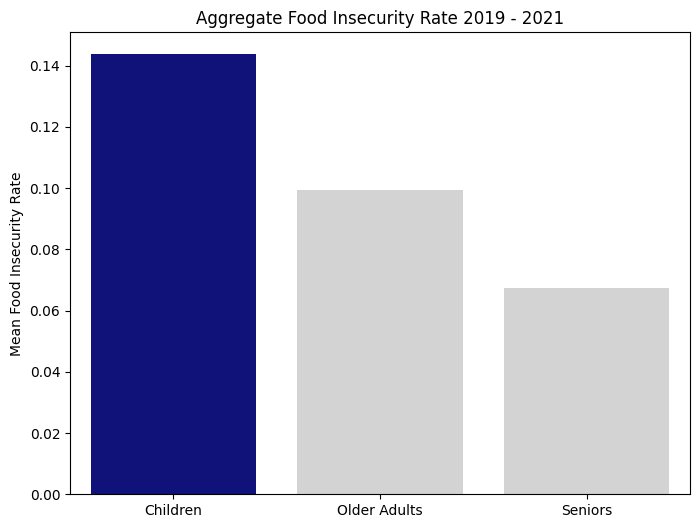

In [8]:
# Calculate the mean food insecurity rate for each category across all years
mean_rate_children = merged_df['ChildFoodInsecurityRate'].mean()
mean_rate_older_adults = merged_df['OlderAdultFoodInsecurityRate'].mean()
mean_rate_seniors = merged_df['SeniorFoodInsecurityRate'].mean()

# Prepar3 data for plotting
categories = ['Children', 'Older Adults', 'Seniors']
mean_rates = [mean_rate_children, mean_rate_older_adults, mean_rate_seniors]

# Plot
plt.figure(figsize=(8, 6))

# Create bar plot
barplot = sns.barplot(x=categories, y=mean_rates, palette=['darkblue', 'lightgray', 'lightgray'])

# Add titles and labels
plt.title('Aggregate Food Insecurity Rate 2019 - 2021')
plt.ylabel('Mean Food Insecurity Rate')

# Remove the 'Category' label from the x-axis
plt.xlabel('')

plt.show()

# Visualization: Correlation Plot for Poverty and Food Insecurity

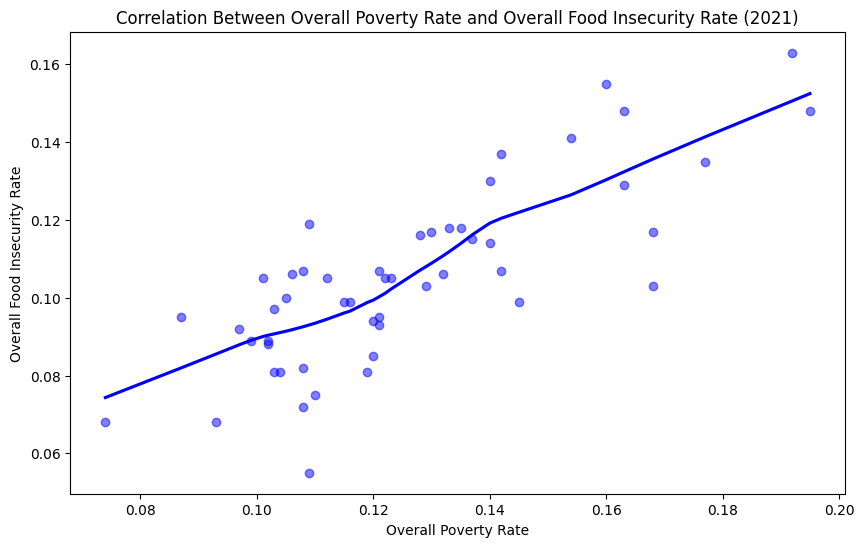

In [9]:
# Plot
plt.figure(figsize=(10, 6))

# Scatter plot with LOESS fit
sns.regplot(x='Poverty_Rate_overall_2021', y='OverallFoodInsecurityRate', data=merged_df, lowess=True,
            scatter_kws={'alpha':0.5}, line_kws={'color': 'blue'}, color='blue')

# Add titles and labels
plt.title('Correlation Between Overall Poverty Rate and Overall Food Insecurity Rate (2021)')
plt.xlabel('Overall Poverty Rate')
plt.ylabel('Overall Food Insecurity Rate')

plt.show()

# Visualization: Pearson Correlation Coefficient Poverty vs Insecurity

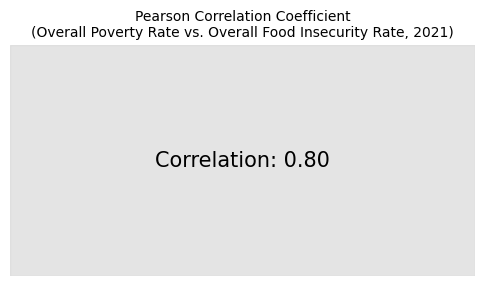

In [10]:
# Calculate Pearson's correlation coefficient between overall poverty rate and overall food insecurity rate for 2021
correlation = merged_df['Poverty_Rate_overall_2021'].corr(merged_df['OverallFoodInsecurityRate'])

fig, ax = plt.subplots(figsize=(6, 3))

# Create a rectangle as the card background
rect = patches.Rectangle((0, 0), 1, 1, transform=ax.transAxes, color="lightgray", alpha=0.6)
ax.add_patch(rect)

# Display the correlation value
correlation_text = f"Correlation: {correlation:.2f}"
plt.text(0.5, 0.5, correlation_text, fontsize=15, ha='center', va='center')

# Set limits and removing axes for clean presentation
plt.xlim(0, 1)
plt.ylim(0, 1)
ax.axis('off')

plt.title('Pearson Correlation Coefficient\n(Overall Poverty Rate vs. Overall Food Insecurity Rate, 2021)', fontsize=10)
plt.show()


# Visualization: Correlation Plot Poverty Rate vs Food Insecurity Rates by Age Group (2021)

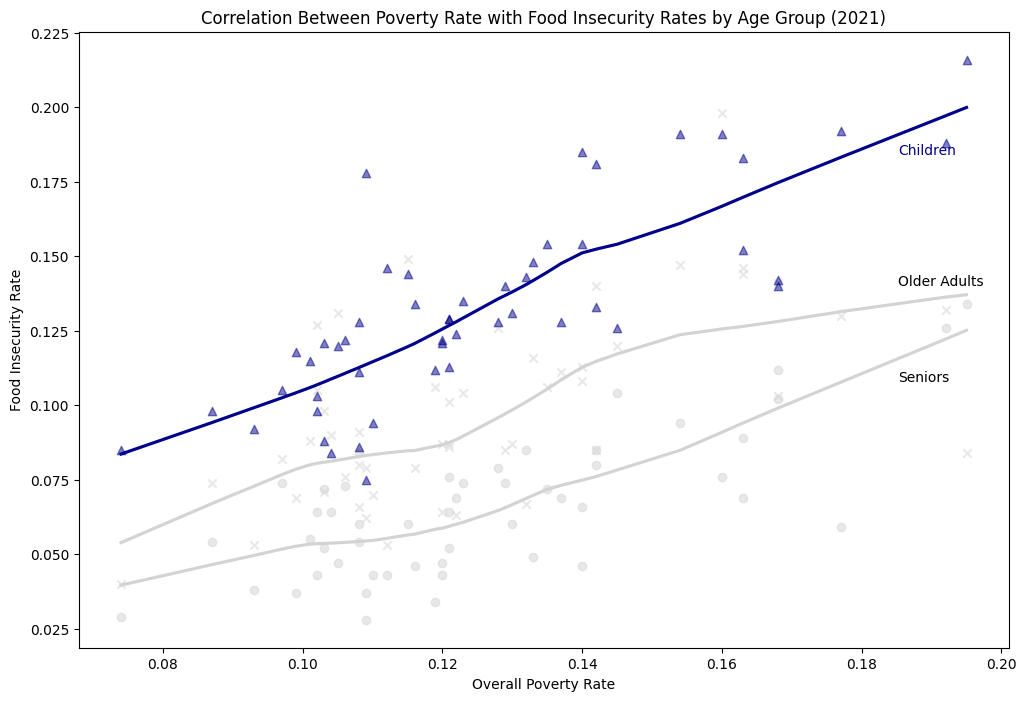

In [11]:
# Plot
plt.figure(figsize=(12, 8))

# Plot seniors and older adults in gray
sns.regplot(x='Poverty_Rate_overall_2021', y='SeniorFoodInsecurityRate', data=merged_df, lowess=True,
            scatter_kws={'alpha':0.5}, marker='o', color='lightgray')
sns.regplot(x='Poverty_Rate_overall_2021', y='OlderAdultFoodInsecurityRate', data=merged_df, lowess=True,
            scatter_kws={'alpha':0.5}, marker='x', color='lightgray')

# Plot children in dark blue
sns.regplot(x='Poverty_Rate_overall_2021', y='ChildFoodInsecurityRate', data=merged_df, lowess=True,
            scatter_kws={'alpha':0.5}, marker='^', color='darkblue')

# Add titles and labels
plt.title('Correlation Between Poverty Rate with Food Insecurity Rates by Age Group (2021)')
plt.xlabel('Overall Poverty Rate')
plt.ylabel('Food Insecurity Rate')

# Determine the x-coordinate for labeling
label_x_position = merged_df['Poverty_Rate_overall_2021'].max() * 0.95

# Determine an offset to move the labels higher
offset = 0.042

# Adjust  label positions to be higher along the y-axis
senior_label_point = merged_df['SeniorFoodInsecurityRate'].mean() + offset
older_adults_label_point = merged_df['OlderAdultFoodInsecurityRate'].mean() + offset
children_label_point = merged_df['ChildFoodInsecurityRate'].mean() + offset

plt.text(label_x_position, senior_label_point, 'Seniors', color='black', verticalalignment='center')
plt.text(label_x_position, older_adults_label_point, 'Older Adults', color='black', verticalalignment='center')
plt.text(label_x_position, children_label_point, 'Children', color='darkblue', verticalalignment='center')

plt.show()


# Visualization: Map of Food Insecurity for Children 2019 - 2021

In [15]:
# Custom color scale
color_scale = [
    (0, 'lightgray'),
    (0.50, 'lightgray'),
    (1, 'darkblue')]

fig = px.choropleth(merged_df,
                    locations="State",
                    color="ChildFoodInsecurityRate",
                    hover_data=["State", "ChildFoodInsecurityRate"],
                    locationmode='USA-states',
                    color_continuous_scale=color_scale)

# Update layout
fig.update_layout(
    title_text='Child Food Insecurity Rates 2019 - 2021',
    geo_scope='usa')

fig.update_coloraxes(colorbar_title="Food Insecurity Rate")

fig.show()

# Visualization: Aggregate Bar Plot Poverty Rates by Age Group 2021

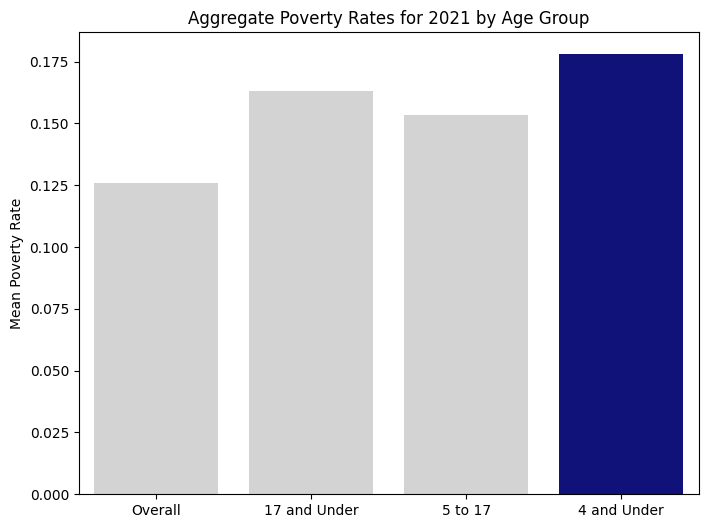

In [13]:
# Filter for the year 2021
df_2021 = merged_df[merged_df['Year'] == 2021]

# Calculate the mean poverty rates for the specified categories in 2021
mean_poverty_overall_2021 = df_2021['Poverty_Rate_overall_2021'].mean()
mean_poverty_under17_2021 = df_2021['Poverty_Rate_under17_2021'].mean()
mean_poverty_5to17_2021 = df_2021['Poverty_Rate_5to17_2021'].mean()
mean_poverty_under4_2021 = df_2021['Poverty_Rate_under4_2021'].mean()

# Prepare data for plotting
categories = ['Overall', '17 and Under', '5 to 17', '4 and Under']
mean_poverty_rates = [mean_poverty_overall_2021, mean_poverty_under17_2021, mean_poverty_5to17_2021, mean_poverty_under4_2021]

# Set colors for each category (all light gray except '4 and Under' in dark blue)
colors = ['lightgray', 'lightgray', 'lightgray', 'darkblue']

# Plot
plt.figure(figsize=(8, 6))

# Create bar plot with specified colors
sns.barplot(x=categories, y=mean_poverty_rates, palette=colors)

# Add  titles and labels
plt.title('Aggregate Poverty Rates for 2021 by Age Group')
plt.ylabel('Mean Poverty Rate')

# Remove the 'Category' label from the x-axis
plt.xlabel('')

plt.show()

# Visualization: Card for Reduction Calculations

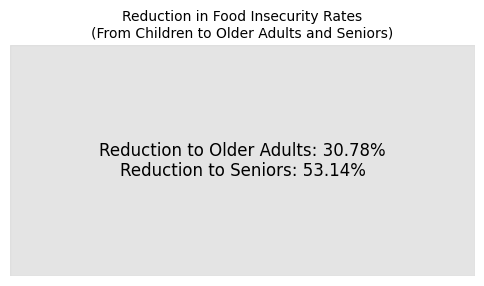

In [18]:
# Calculate the mean food insecurity rate for each category
mean_rate_children = merged_df['ChildFoodInsecurityRate'].mean()
mean_rate_older_adults = merged_df['OlderAdultFoodInsecurityRate'].mean()
mean_rate_seniors = merged_df['SeniorFoodInsecurityRate'].mean()

# Calculate the percentage reductions
reduction_older_adults_percent = ((mean_rate_children - mean_rate_older_adults) / mean_rate_children) * 100
reduction_seniors_percent = ((mean_rate_children - mean_rate_seniors) / mean_rate_children) * 100

# Plotting the visual card
fig, ax = plt.subplots(figsize=(6, 3))
rect = patches.Rectangle((0, 0), 1, 1, transform=ax.transAxes, color="lightgray", alpha=0.6)
ax.add_patch(rect)

reduction_text = f"Reduction to Older Adults: {reduction_older_adults_percent:.2f}%\nReduction to Seniors: {reduction_seniors_percent:.2f}%"
plt.text(0.5, 0.5, reduction_text, fontsize=12, ha='center', va='center', transform=ax.transAxes)

plt.xlim(0, 1)
plt.ylim(0, 1)
ax.axis('off')

plt.title('Reduction in Food Insecurity Rates\n(From Children to Older Adults and Seniors)', fontsize=10)
plt.show()